In [6]:
# Import packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Matplotlib.use("Agg")
import datetime as dt

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinL-Library")

import itertools

In [7]:
# Create folders
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [8]:
# Print
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [12]:
# Train model
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2023-02-03'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-02-03'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
df.sort_values(["date", "tic"]).head()

,date,open,high,low,close,volume,tic,day
0,2009-04-01,3.717500,3.892857,3.710357,3.308904,589372000,AAPL,2
1,2009-04-01,48.779999,48.930000,47.099998,36.228382,10850100,AMGN,2
2,2009-04-01,13.340000,14.640000,13.080000,11.732110,27701800,AXP,2
3,2009-04-01,34.520000,35.599998,34.209999,26.850746,9288800,BA,2
4,2009-04-01,27.500000,29.520000,27.440001,19.726320,15308300,CAT,2


In [11]:
len(df.tic.unique())

30

In [14]:
df.tic.value_counts()

AAPL    3485
AMGN    3485
WMT     3485
WBA     3485
VZ      3485
V       3485
UNH     3485
TRV     3485
PG      3485
NKE     3485
MSFT    3485
MRK     3485
MMM     3485
MCD     3485
KO      3485
JPM     3485
JNJ     3485
INTC    3485
IBM     3485
HON     3485
HD      3485
GS      3485
DIS     3485
CVX     3485
CSCO    3485
CRM     3485
CAT     3485
BA      3485
AXP     3485
DOW      977
Name: tic, dtype: int64

In [15]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
6893,2010-03-11,28.889999,29.190001,28.850000,22.433073,35349700,MSFT,3,0.003506,22.500763,21.486596,52.395181,128.318584,0.640525,21.866085,22.575625,0.000000
5468,2009-12-29,28.725000,28.985001,28.725000,19.315783,9551000,KO,1,0.099385,19.805910,18.887554,59.614015,14.220057,2.193213,19.256475,18.671514,0.000000
77407,2019-11-06,47.810001,48.500000,47.790001,43.608654,15904500,CSCO,2,-0.007324,43.537887,41.472335,49.541006,103.800261,1.313094,42.645460,43.038767,17.296223
87694,2021-04-06,56.480000,57.049999,55.529999,51.767410,4807700,WBA,1,1.419033,52.918669,45.732163,63.791002,126.615230,41.735420,47.730416,46.450452,13.658040
30529,2013-06-06,30.870001,31.090000,30.605000,28.018730,4761400,NKE,3,-0.008309,29.842317,27.528025,53.408852,-116.681562,23.923995,28.605418,27.479068,37.715215


In [17]:
# Part 5: Design environment
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [19]:
# Part 6: Implement DRL Algorithms
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [21]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [23]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,PPO_model_kwargs,DDPG_model_kwargs, timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.71778721436522
======Model training from:  2009-04-01 to  2021-01-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
--------------------------------------
| time/                 |            |
|    fps                | 30         |
|    iterations         | 100        |
|    time_elapsed       | 16         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.0235    |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -70.1      |
|    reward             | -0.0617484 |
|    std                | 1          |
|    value_loss         | 8.91       |
--------------------------------------
------------------------------------
| time/                 |          |
|    fps      

---------------------------------------
| time/                 |             |
|    fps                | 88          |
|    iterations         | 1400        |
|    time_elapsed       | 79          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -41         |
|    explained_variance | -0.235      |
|    learning_rate      | 0.0007      |
|    n_updates          | 1399        |
|    policy_loss        | 158         |
|    reward             | -0.38163617 |
|    std                | 0.997       |
|    value_loss         | 18.1        |
---------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 89       |
|    iterations         | 1500     |
|    time_elapsed       | 83       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -41.1    |
|    explained_variance | 0        |
|    learning_rate      | 0

======PPO Validation from:  2021-01-04 to  2021-04-06
PPO Sharpe Ratio:  0.46512811448621694
======DDPG Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_126_1
day: 2959, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 6602945.24
total_reward: 5602945.24
total_cost: 1774.71
total_trades: 47410
Sharpe: 0.919
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 50        |
|    time_elapsed    | 232       |
|    total_timesteps | 11840     |
| train/             |           |
|    actor_loss      | 19.2      |
|    critic_loss     | 135       |
|    learning_rate   | 0.0005    |
|    n_updates       | 8880      |
|    reward          | 2.9014924 |
----------------------------------
======DDPG Validation from:  2021-01-04 to  2021-04-06
======Best Model Retraining from:  2009-04-01 to  2021-04-06
======Trading from:  2

----------------------------------------
| time/                 |              |
|    fps                | 99           |
|    iterations         | 1300         |
|    time_elapsed       | 65           |
|    total_timesteps    | 6500         |
| train/                |              |
|    entropy_loss       | -41.4        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 1299         |
|    policy_loss        | -34.5        |
|    reward             | -0.090856306 |
|    std                | 1.01         |
|    value_loss         | 0.913        |
----------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 98         |
|    iterations         | 1400       |
|    time_elapsed       | 70         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | 1.19e-

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 5           |
|    time_elapsed         | 90          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.014680959 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | 0.0199      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.8         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0269     |
|    reward               | 0.52533     |
|    std                  | 1           |
|    value_loss           | 10.3        |
-----------------------------------------
======PPO Validation from:  2021-04-06 to  2021-07-06
PPO Sharpe Ratio:  0.07742065423730403
======DDPG Training========
{'buffer_size': 10000, 'learning_rate':

------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 1100     |
|    time_elapsed       | 58       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -41.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1099     |
|    policy_loss        | -604     |
|    reward             | 5.579208 |
|    std                | 1        |
|    value_loss         | 183      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 93        |
|    iterations         | 1200      |
|    time_elapsed       | 63        |
|    total_timesteps    | 6000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 11

-----------------------------------------
| time/                   |             |
|    fps                  | 86          |
|    iterations           | 4           |
|    time_elapsed         | 94          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.015337056 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | -0.0127     |
|    learning_rate        | 0.00025     |
|    loss                 | 21.8        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0248     |
|    reward               | 0.13882045  |
|    std                  | 1.01        |
|    value_loss           | 35.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 5     

--------------------------------------
| time/                 |            |
|    fps                | 100        |
|    iterations         | 1000       |
|    time_elapsed       | 49         |
|    total_timesteps    | 5000       |
| train/                |            |
|    entropy_loss       | -41.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 999        |
|    policy_loss        | 301        |
|    reward             | -1.9685837 |
|    std                | 0.999      |
|    value_loss         | 70.1       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 100       |
|    iterations         | 1100      |
|    time_elapsed       | 54        |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 3           |
|    time_elapsed         | 60          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.013040769 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00692    |
|    learning_rate        | 0.00025     |
|    loss                 | 30.3        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0212     |
|    reward               | 5.697745    |
|    std                  | 1           |
|    value_loss           | 73.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 4     

--------------------------------------
| time/                 |            |
|    fps                | 100        |
|    iterations         | 900        |
|    time_elapsed       | 44         |
|    total_timesteps    | 4500       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 899        |
|    policy_loss        | 0.751      |
|    reward             | -0.6211127 |
|    std                | 1.01       |
|    value_loss         | 0.95       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 100       |
|    iterations         | 1000      |
|    time_elapsed       | 49        |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 3           |
|    time_elapsed         | 61          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.013932576 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00294    |
|    learning_rate        | 0.00025     |
|    loss                 | 31.8        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0166     |
|    reward               | -2.8249795  |
|    std                  | 1           |
|    value_loss           | 61.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 4     

---------------------------------------
| time/                 |             |
|    fps                | 94          |
|    iterations         | 800         |
|    time_elapsed       | 42          |
|    total_timesteps    | 4000        |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 799         |
|    policy_loss        | 15.6        |
|    reward             | -0.16102567 |
|    std                | 1           |
|    value_loss         | 0.29        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 95         |
|    iterations         | 900        |
|    time_elapsed       | 47         |
|    total_timesteps    | 4500       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    lear

----------------------------------
| time/              |           |
|    fps             | 100       |
|    iterations      | 1         |
|    time_elapsed    | 20        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.8093812 |
----------------------------------
day: 3274, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 6515412.89
total_reward: 5515412.89
total_cost: 460172.09
total_trades: 91521
Sharpe: 0.944
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 2           |
|    time_elapsed         | 41          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014011628 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00265    |
|    learning_rate  

--------------------------------------
| time/                 |            |
|    fps                | 100        |
|    iterations         | 600        |
|    time_elapsed       | 29         |
|    total_timesteps    | 3000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 599        |
|    policy_loss        | -857       |
|    reward             | -14.505035 |
|    std                | 1          |
|    value_loss         | 587        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 101        |
|    iterations         | 700        |
|    time_elapsed       | 34         |
|    total_timesteps    | 3500       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 102       |
|    iterations         | 2000      |
|    time_elapsed       | 97        |
|    total_timesteps    | 10000     |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.000339 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1999      |
|    policy_loss        | 90.8      |
|    reward             | -6.584981 |
|    std                | 1         |
|    value_loss         | 35.6      |
-------------------------------------
======A2C Validation from:  2022-07-06 to  2022-10-04
A2C Sharpe Ratio:  -0.12222367709856709
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_504_1
----------------------------------
| time/              |           |
|    fps             | 106       |
|    iterations      | 1   

In [24]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,PPO,0.330909,0.465128,0.313868
1,189,2021-04-06,2021-07-06,A2C,0.406824,0.077421,0.199229
2,252,2021-07-06,2021-10-04,DDPG,-0.075349,-0.154251,0.04376
3,315,2021-10-04,2022-01-03,DDPG,0.131305,0.146738,0.318529
4,378,2022-01-03,2022-04-04,PPO,-0.352485,-0.172306,-0.188207
5,441,2022-04-04,2022-07-06,DDPG,-0.23592,-0.266577,-0.183741
6,504,2022-07-06,2022-10-04,DDPG,-0.122224,-0.250686,-0.082144


In [25]:
# Part 7: Backtest our strategy
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [26]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.06760444354192185


In [27]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-04-06,NaN,2021-04-06
1,1.000150e+06,2021-04-07,0.000150,2021-04-07
2,1.000808e+06,2021-04-08,0.000658,2021-04-08
3,1.005328e+06,2021-04-09,0.004516,2021-04-09
4,1.004073e+06,2021-04-12,-0.001248,2021-04-12


<AxesSubplot:>

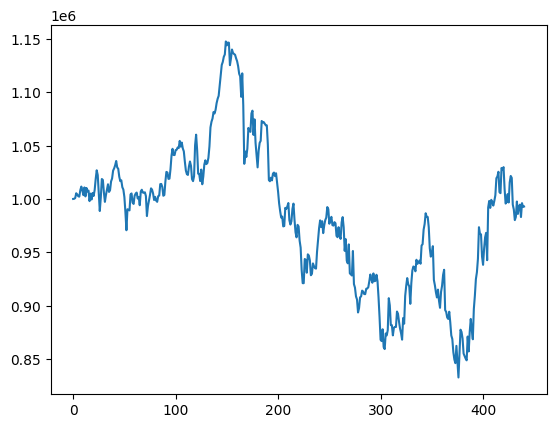

In [28]:
%matplotlib inline
df_account_value.account_value.plot()

In [30]:
print("==============Get Backtest Results===========")
now = dt.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.004084
Cumulative returns    -0.007136
Annual volatility      0.180872
Sharpe ratio           0.067604
Calmar ratio          -0.014876
Stability              0.320399
Max drawdown          -0.274529
Omega ratio            1.011795
Sortino ratio          0.095592
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.972834
Daily value at risk   -0.022739
dtype: float64


In [34]:
# Baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="AAPL", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)
Annual return          0.022874
Cumulative returns     0.040278
Annual volatility      0.306154
Sharpe ratio           0.226531
Calmar ratio           0.075368
Stability              0.082969
Max drawdown          -0.303492
Omega ratio            1.038506
Sortino ratio          0.325852
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.897916
Daily value at risk   -0.038297
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2021-04-06
End date,2023-01-03
Total months,21
,Backtest
Annual return,-0.408%
Cumulative returns,-0.714%
Annual volatility,18.087%
Sharpe ratio,0.07
Calmar ratio,-0.01
Stability,0.32
Max drawdown,-27.453%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.45,2021-11-04,2022-09-30,NaT,NaN
1,6.27,2021-06-04,2021-06-18,2021-08-20,56
2,4.38,2021-09-24,2021-10-04,2021-10-14,15
3,3.72,2021-05-07,2021-05-12,2021-06-02,19
4,3.58,2021-09-01,2021-09-21,2021-09-24,18


Stress Events,mean,min,max
New Normal,0.00%,-5.06%,5.25%


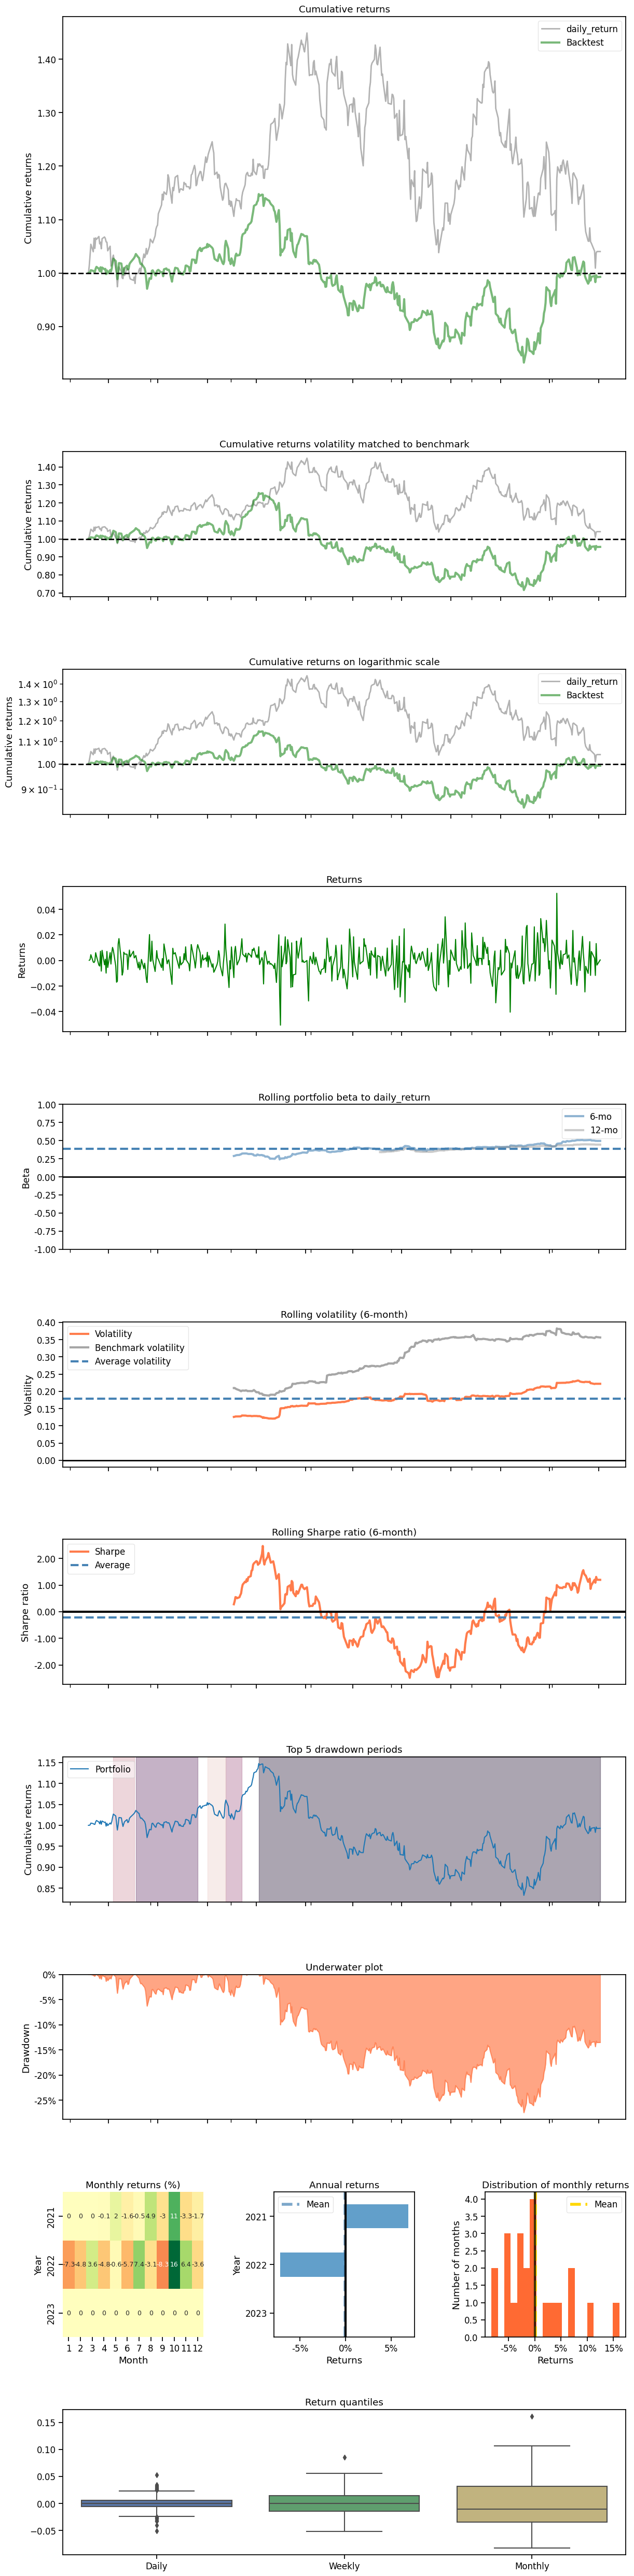

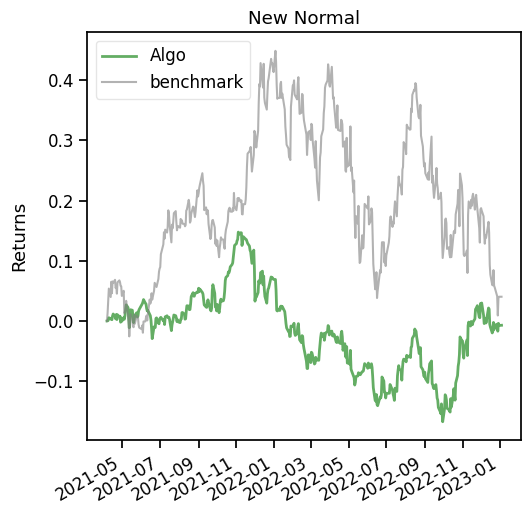

In [35]:
# BackTestPlot
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = 'AAPL', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])